# Using a Pre-Trained Conv-net

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `os`, `numpy`, `matplotlib`, `skimage`, `torch`, `torch.nn`, `torch.nn.functional` and `torchvision`.

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import skimage
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
import imagenet_classes

## Setup device

Choose the first CUDA device `cuda:0`:

In [3]:
torch_device = torch.device('cuda:0')

## Load an image to classify

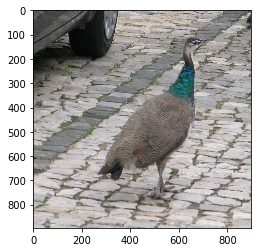

In [4]:
IMAGE_PATH = os.path.join('images', 'P1013781.JPG')
# Extract a 896 x 896 block surrounding the peacock
img = plt.imread(IMAGE_PATH)[1800:2696,652:1548]
plt.imshow(img)
plt.show()

## Build the network

The `torchvision` package provides a number of pre-trained classification models, one of which is VGG-16.

### The architecture
VGG networks consist of convolutional layers that use 3x3 convolutional kernels and pad the input to ensure that the output size remains the same as the input size. Since a 3x3 convolution will reduce the size of the image by two pixels, this means that the image must be zero-padded by 1 pixel at each side.

#### A note about processing images with conv-nets in PyTorch

Convolutional networks in PyTorch expect images to come in the form of 4-dimensional arrays rather than 3-dimensional ones. The dimensions are: `(sample, channel, height, width)`. The `sample` dimension allows you to stack a number of images in a mini-batch so that you can predict (or train) a number of images in one go. The `channel` dimension divides an image into one plane per channel, where channels are R, G and B for the input or more complex representations corresponding to filters further down the network. The `height` and `width` dimensions are the `Y` and `X` axes of the image.

For example: to store 128 RGB images of 224 x 224, you would need an array of size `(128, 3, 224, 224)`.

The `torchvision` models expect images to be standardised; the RGB values must be standardised; the mean RGB of the ImageNet dataset should be subtracted and the values should be scaled by the reciprocal of the standard deviation. These values are constants used for all of the [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html):

`mean=[0.485, 0.456, 0.406]`

`std=[0.229, 0.224, 0.225]`

In [5]:
# Build it, requesting that the pre-trained model weights are loaded
# The call to the `to` method moves it onto the GPU
vgg16_net = torchvision.models.vgg.vgg16(pretrained=True).to(torch_device)

# Call the eval() method; we are not training
vgg16_net.eval()

# Also, set a variable 
MODEL_MEAN = np.array([0.485, 0.456, 0.406])
MODEL_STD = np.array([0.229, 0.224, 0.225])

## Preparing the image for classification

There are a few transformations we must perform on the image to get it into a form that VGG-net can operate on:

- we must scale and crop the image to 224x224, as this is the size that VGG net expects
- The PyTorch pre-trained models expect the RGB channels to be in the range [0,1], so convert the image from `uint8` type to `np.float32`
- subtract the image mean supplied by the network parameters
- ensure that the axes are `(sample, channel, height, width)`

In [6]:
def vgg_prepare_image(im, image_mean, image_std, image_size=224):
    # If the image is greyscale, convert it to RGB
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
        
    # Convert to float type
    im = skimage.util.img_as_float(im)
        
    # Scale the image so that its smallest dimension is the desired size
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (image_size, w * image_size / h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h * image_size / w, image_size), preserve_range=True)
        
    # Crop the central `image_size` x `image_size` region of the image
    h, w, _ = im.shape
    im = im[h//2 - image_size // 2:h // 2 + image_size // 2, w // 2 - image_size // 2:w // 2 + image_size // 2]
    
    rawim = im.copy()

    # Shuffle axes from (height, width, channel) to (channel, height, width)
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)

    # Subtract the mean and divide by the std-dev
    # Note that we add two axes to the mean and std-dev for height and width so that they broadcast with the image array
    im = (im - image_mean[:, None, None]) / image_std[:, None, None]
    
    # Add the sample axis to the image; (channel, height, width) -> (sample, channel, height, width)
    im = im[None, ...]
    
    return rawim, im.astype(np.float32)

Transform the image:

D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda\envs\pytorch1\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


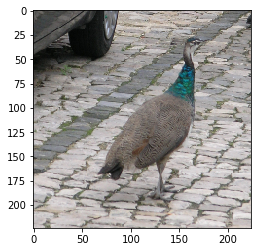

In [7]:
raw_img, img_for_vgg = vgg_prepare_image(img, image_mean=MODEL_MEAN, image_std=MODEL_STD)
plt.imshow(raw_img)
plt.show()

Run the image through the network, generating a matrix of probabilities; each row of the matrix represents the probabilities of the corresponding image from the batch.

We must first convert `img_for_vgg` -- which is a NumPy array -- to a PyTorch tensor. After that we apply the network by calling it as if it were a function to generate logits. We then apply the `F.softmax` function to get probability vectors. Finally we convert back to a NumPy array.

In [9]:
# We don't need gradients here as we are only performing inference/prediction
with torch.no_grad():
    t_im = torch.tensor(img_for_vgg, dtype=torch.float, device=torch_device)

    pred_logits = vgg16_net(t_im)
    pred_prob = F.softmax(pred_logits, dim=1)   # dim=1: normalize over the probability vector axis
    pred_prob = pred_prob.detach().cpu().numpy()  # detach from gradients, move to CPU, convert to NumPy

print(pred_prob.shape)

(1, 1000)


Use `np.argmax` to get the index of the class with the maximum probability:

In [10]:
pred_cls = np.argmax(pred_prob, axis=1)
print('Predicted class index {} with probability {:.2f}%, named "{}"'.format(
    pred_cls[0], pred_prob[0, pred_cls[0]]*100.0, imagenet_classes.IMAGENET_CLASSES[pred_cls[0]]))

Predicted class index 84 with probability 99.97%, named "peacock"
